## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL: 

# Business Problem



### We are a streaming service that wants to increase the value of it's service and grow it's user and movie base.

Goal: create a recommendation engine that will accurately predict movies that our users will rate highly.

Benefits:
1. Keeps our existing users coming back
    - Recommending movies they like and showing them movies they haven't seen will keep them interested
2. Helps identify movies to add to the service
    - New content will give users more movies to watch, keeping them on the service longer
3. Attracts new users
    - A well curated collection of movies will encourage streamers to use our service

## The Data

The data used in the project is a rating data sets from the MovieLens web site (https://movielens.org) collected by GroupLens Research. The particular dataet used is the ml-latest-small set. 

This dataset describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains: 
- 100836 ratings 
- 3683 tag applications
- 9742 movies
- 610 users 

This is a small, development dataset collected between March 29, 1996 and September 24, 2018, and was generated on September 26, 2018. 

Users were selected at random for inclusion. All selected users had rated at least 20 movies. 
- Each user is represented by an id, and no other information is provided. 

The data are contained in the files:
- data/links.csv
- data/movies.csv
- data/ratings.csv 
- data/tags.csv. 

# Setup

### Import relevant packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import json

from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import train_test_split
from surprise import accuracy

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Clean Data

Load the raw csv files

In [2]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

### Movies DataFrame

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Ratings DataFrame
- drop the timestamp column

In [4]:
ratings = ratings_df.drop(columns=['timestamp'], axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Tags DataFrame
- drop the timestamp column

In [5]:
tags = tags_df.drop(columns=['timestamp'], axis=1)
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


## Total Dataset Visualizations
Visualizations to gain an comprehensive view of the data

### Most common tags
- Look at the tags DataFrame to determine which tags occur the most often

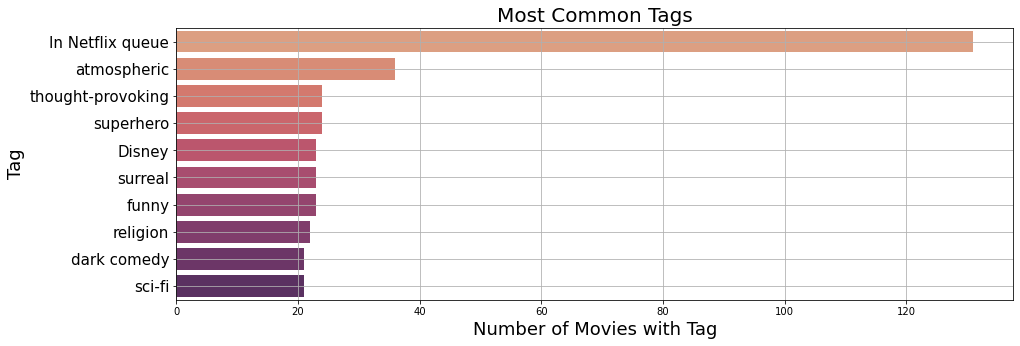

In [6]:
# group tags together and count their number of occurances. Sort by most common
tags_group = tags.drop(columns='userId', axis=1)
tags_group = tags_group.groupby('tag').count().sort_values(by='movieId', ascending=False)
tags_group = tags_group.rename(columns={'movieId': 'Count'})
top_tag_groups = tags_group[:10]

# plot the 10 most common tags
plt.figure(figsize=(15,5))
sns.barplot(data=top_tag_groups, x='Count', y=top_tag_groups.index, palette='flare')
plt.yticks(fontsize=15)
plt.xlabel('Number of Movies with Tag', fontsize=18)
plt.ylabel('Tag', fontsize=18)
plt.title('Most Common Tags', fontsize=20)
plt.grid()

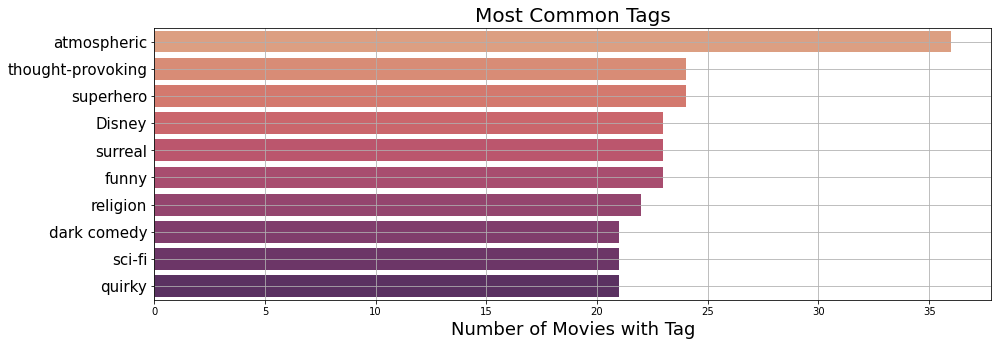

In [7]:
# plot the 10 most common tags, removing the tag "In Netfix Queue"
top_tag_groups = tags_group[1:11]

plt.figure(figsize=(15,5))
sns.barplot(data=top_tag_groups, x='Count', y=top_tag_groups.index, palette='flare')
plt.yticks(fontsize=15)
plt.xlabel('Number of Movies with Tag', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Most Common Tags', fontsize=20)
plt.grid()

### Genre counts
- Determine how many movies belonging to each genre exist in the data set

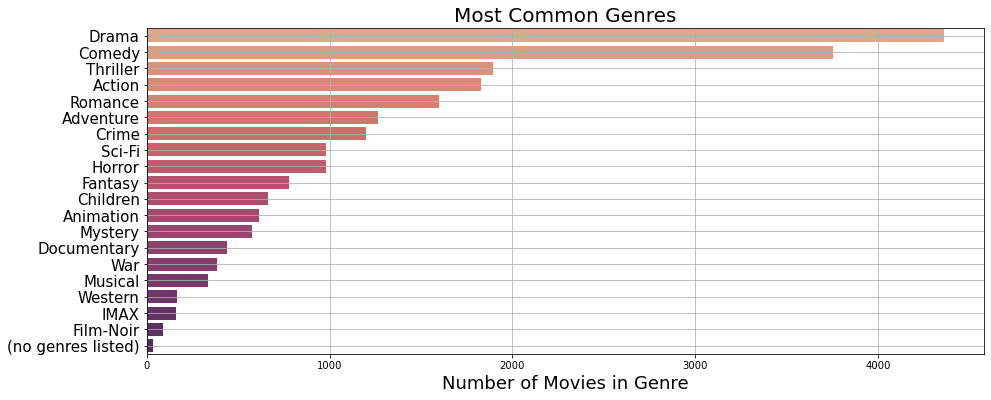

In [8]:
# drop the titles from the dataframe
genres = movies_df.drop(columns=['title'], axis=1)

# convert genre tags to list
genres['genres'] = genres['genres'].map(lambda x: x.split('|'))
genres = genres.explode('genres')

# group the rows by genre and count the number of occurances, then sort
genres_group = genres.groupby('genres').count().sort_values(by='movieId', ascending=False)
genres_group = genres_group.rename(columns={'movieId': 'Count'})
top_genres_group = genres_group[:20]

plt.figure(figsize=(15,6))
sns.barplot(data=top_genres_group, x='Count', y=top_genres_group.index, palette='flare')
plt.yticks(fontsize=15)
plt.xlabel('Number of Movies in Genre', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Most Common Genres', fontsize=20)
plt.grid()

### Histogram of Ratings
- view the distribution of ratings in the data set

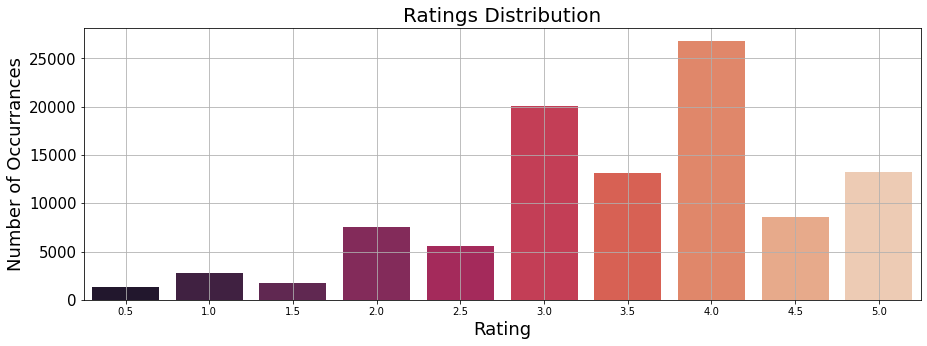

In [9]:
# count the number of occurances for each rating
ratings_count = ratings.groupby("rating").count()
ratings_count.drop(columns=["userId"], axis=1)
ratings_count = ratings_count.rename(columns={'movieId': 'Count'})

plt.figure(figsize=(15,5))
sns.barplot(data=ratings_count, x=ratings_count.index, y='Count', palette="rocket")
plt.yticks(fontsize=15)
plt.xlabel('Rating', fontsize=18)
plt.ylabel('Number of Occurrances', fontsize=18)
plt.title('Ratings Distribution', fontsize=20)
plt.grid()

## Create a Surprise Dataset from the Ratings DataFrame

In [10]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [11]:
dataset = data.build_full_trainset()
print(f"N users = {dataset.n_users}")
print(f"N items = {dataset.n_items}")

N users = 610
N items = 9724


## Separate the data into test and train data

In [12]:
trainset, testset = train_test_split(data, test_size=0.2)

## Create a function to train and test each KNN method

Define the parameter combinations for the KNN methods

In [13]:
sim_cos_item = {"name": "cosine", "user_based": False}
sim_pearson_item = {"name": "pearson", "user_based": False}
sim_cos_user = {"name": "cosine", "user_based": True}
sim_pearson_user = {"name": "pearson", "user_based": True}

Define a model to run a KNN method type model and return the error of the model

In [14]:
def run_KNN_model(method_type, params):
    """
    function to run k-Nearest Neightbor inspired methods to compare users and items for similarity.
    
    args: 
        - method_type: KNN method type to use: KNNBasi, KNNBaseline, or KNNWithMeans
        - params: paramters to use in model, including "name", and "user_based"
    returns: 
        - accuracy_rmse: root mean squared error for the model
        - accuracy_mae: mean aboslute error for the model
    """
    if method_type == 'KNNBasic':
        model = KNNBasic(sim_options=params, verbose=False)
    elif method_type == 'KNNBaseline':
        model = KNNBaseline(sim_options=params, verbose=False)
    elif method_type == 'KNNWithMeans':
        model = KNNWithMeans(sim_options=params, verbose=False)
    else:
        return 'not a model'

    model.fit(trainset)
    predictions = model.test(testset)
    accuracy_rmse = accuracy.rmse(predictions, verbose=False)
    accuracy_mae = accuracy.mae(predictions, verbose=False)
#     cv = cross_validate(model, data)
    
    return accuracy_rmse, accuracy_mae

# Run several models to determine the most accurate final model
- KNN Basic methods
- KNN Baseline methods
- KNN With Means methods
- Singular Value Decomposition
    - using a grid search to determine the optimal parameters

## Train and Test KNN Basic Methods

In [15]:
basic_p_u_rmse, basic_p_u_mae = run_KNN_model("KNNBasic", sim_pearson_user)
print(f'basic pearson user: rmse = {round(basic_p_u_rmse, 4)}, mae = {round(basic_p_u_mae, 4)}')

basic_p_i_rmse, basic_p_i_mae = run_KNN_model("KNNBasic", sim_pearson_item)
print(f'basic pearson item: rmse = {round(basic_p_i_rmse, 4)}, mae = {round(basic_p_i_mae, 4)}')

basic_c_u_rmse, basic_c_u_mae = run_KNN_model("KNNBasic", sim_cos_user)
print(f'basic cosine user: rmse = {round(basic_c_u_rmse, 4)}, mae = {round(basic_c_u_mae, 4)}')

basic_c_i_rmse, basic_c_i_mae = run_KNN_model("KNNBasic", sim_cos_item)
print(f'basic cosine item: rmse = {round(basic_c_i_rmse, 4)}, mae = {round(basic_c_i_mae, 4)}')

basic pearson user: rmse = 0.9671, mae = 0.7491
basic pearson item: rmse = 0.9697, mae = 0.7519
basic cosine user: rmse = 0.9684, mae = 0.7486
basic cosine item: rmse = 0.9771, mae = 0.7608


## Train and Test KNN Baseline Methods

In [16]:
base_p_u_rmse, base_p_u_mae = run_KNN_model('KNNBaseline', sim_pearson_user)
print(f'baseline pearson user: rmse = {round(base_p_u_rmse, 4)}, mae = {round(base_p_u_mae, 4)}')

base_p_i_rmse, base_p_i_mae = run_KNN_model('KNNBaseline', sim_pearson_item)
print(f'baseline pearson item: rmse = {round(base_p_i_rmse, 4)}, mae = {round(base_p_i_mae, 4)}')

base_c_u_rmse, base_c_u_mae = run_KNN_model('KNNBaseline', sim_cos_user)
print(f'baseline cosine user: rmse = {round(base_c_u_rmse, 4)}, mae = {round(base_c_u_mae, 4)}')

base_c_i_rmse, base_c_i_mae = run_KNN_model('KNNBaseline', sim_cos_item)
print(f'baseline cosine item: rmse = {round(base_c_i_rmse, 4)}, mae = {round(base_c_i_mae, 4)}')

baseline pearson user: rmse = 0.8779, mae = 0.6722
baseline pearson item: rmse = 0.8796, mae = 0.6764
baseline cosine user: rmse = 0.8798, mae = 0.6743
baseline cosine item: rmse = 0.8911, mae = 0.6869


## Train and Test KNN With Means Methods

In [17]:
means_p_u_rmse, means_p_u_mae = run_KNN_model('KNNWithMeans', sim_pearson_user)
print(f'means pearson user: rmse = {round(means_p_u_rmse, 4)}, mae = {round(means_p_u_mae, 4)}')

means_p_i_rmse, means_p_i_mae = run_KNN_model('KNNWithMeans', sim_pearson_item)
print(f'means pearson item: rmse = {round(means_p_i_rmse, 4)}, mae = {round(means_p_i_mae, 4)}')

means_c_u_rmse, means_c_u_mae = run_KNN_model('KNNWithMeans', sim_cos_user)
print(f'means cosine user: rmse = {round(means_c_u_rmse, 4)}, mae = {round(means_c_u_mae, 4)}')

means_c_i_rmse, means_c_i_mae = run_KNN_model('KNNWithMeans', sim_cos_item)
print(f'means cosine item: rmse = {round(means_c_i_rmse, 4)}, mae = {round(means_c_i_mae, 4)}')

means pearson user: rmse = 0.8991, mae = 0.687
means pearson item: rmse = 0.9052, mae = 0.6915
means cosine user: rmse = 0.9036, mae = 0.6926
means cosine item: rmse = 0.9066, mae = 0.6946


## Train and Test SVD Methods

In [18]:
grid_search_params = {'n_factors': [30, 40, 50, 60, 70, 80, 90, 100, 110],
                      'reg_all': [0.02, 0.04, 0.05, 0.06, 0.07, 0.1],
                      'n_epochs': [5, 10],
                      'lr_all': [0.005, 0.01]}
g_s_svd = GridSearchCV(SVD, param_grid=grid_search_params, n_jobs=-1)
g_s_svd.fit(data)

print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8685917776473765, 'mae': 0.6673916118640147}
{'rmse': {'n_factors': 40, 'reg_all': 0.04, 'n_epochs': 10, 'lr_all': 0.01}, 'mae': {'n_factors': 40, 'reg_all': 0.02, 'n_epochs': 10, 'lr_all': 0.01}}


## Define the Final Model

### Final Model: SVD model with the parameters;
    - n_factors = 80
    - reg_all = 0.05
    - n_epochs = 10
    - lr_all = 0.01
    
This model resulted in the lowest root mean squared error, of 0.8694

In [19]:
# final_model = KNNBaseline(sim_options=sim_pearson_item, verbose=False)
svd_best_rmse = g_s_svd.best_params['rmse']
final_model = SVD(n_factors=svd_best_rmse ['n_factors'], reg_all=svd_best_rmse ['reg_all'], n_epochs=svd_best_rmse['n_epochs'] , lr_all=svd_best_rmse['lr_all'])
final_model.fit(dataset)

## Functions for filtering ratings and rankings based on key words

Define several functions to filter a user's movie ratings and predictions based on the tags and genres of movies they've rated 4.0 and above

In [20]:
def get_user_ratings(ratings, userId):
    """
    function to obtain a DataFrame of ratings made by a specific user
    """
    user_ratings = ratings[ratings.userId == userId]
    return user_ratings

In [21]:
def look_up_tags(movieId):
    """
    Look up the tags associated with a given movie Id
    """
    tags_list = tags[tags['movieId']==movieId]['tag']
    tags_string = []
    for tag in tags_list:
        tags_string.append(tag)
    return list(np.unique(np.array(tags_string)))

In [22]:
def get_user_top_tags(user_ratings):
    """
    filter the tags submitted by a given user to only contain the tags for movies with ratings 4.0 or higher
    """
    top_tags = []
    for movieId in user_ratings[user_ratings.rating > 3.5].movieId:
        top_tags.extend(look_up_tags(movieId))
    return list(np.unique(np.array(top_tags)))

In [23]:
def filter_ratings_by_key_words(words):
    """
    filter the whole set of genres and tags to only contain genres or tags containted 
    within the given list of key words
    """
    # check both tags and genres
    ids = []
    for word in words:
        ids.extend(genres[genres.genres == word].movieId)
        ids.extend(tags[tags.tag == word].movieId)
    
    ids = list(np.unique(np.array(ids)))
    
    filtered_ratings = ratings[ratings.movieId.isin(ids)]
    
    return filtered_ratings

## Functions for generating recommendations for a given user

In [24]:
def rank_movies(userId, ratings):
    """
    obtain a sorted (ranked) list of movies based on their predicted rating by a given user
    """
    movies_list = []
    for movie_id in ratings.index.unique():
        user_prediction = final_model.predict(userId, movie_id)
        predicted_rating = user_prediction[3]
        movies_list.append((movie_id, predicted_rating))

    ranked_movies = sorted(movies_list, key=lambda x:x[1], reverse=True)
    
    return ranked_movies

In [25]:
def look_up_movie(movieId):
    """
    look up the title of a movie given it's movieId
    """
    title = movies_df[movies_df['movieId']==movieId]['title']
    title_string = title[title.index[0]]
    return title_string

In [26]:
def get_recommended_titles(n_recs, ranked_movies):
    """
    get a list of a specified number of recommended titles for a user, given their predicted movie ratings, ranked
    """
    return [look_up_movie(id[0]) for id in ranked_movies[0:n_recs]]

In [27]:
def recommend_to_user(userId, n_recs, use_words=False):
    """
    generated a list of n movies to recommend to users, with the option to filter the recommendations by key words
    """
    words = []
    filtered_ratings = ratings
    
    if use_words:
        user_ratings = get_user_ratings(ratings, user_id)
        words = get_user_top_tags(user_ratings)
        filtered_ratings = filter_ratings_by_key_words(words)
        
    ranked_movies = rank_movies(userId, filtered_ratings)
    recommended_titles = get_recommended_titles(n_recs, ranked_movies)
    
    return recommended_titles

In [28]:
# test recommendation functions
user_id = 1
n_recs = 5

# user_ratings = get_user_ratings(ratings, user_id)
# words = get_user_top_tags(user_ratings)

recommend_to_user(user_id, n_recs, use_words=True)

['Hoop Dreams (1994)',
 'Pulp Fiction (1994)',
 'Shawshank Redemption, The (1994)',
 'Blade Runner (1982)',
 'Ghost in the Shell (Kôkaku kidôtai) (1995)']

# Cold Start Problem
How do we recommend movies to a new user?

1. recommend the top 5 highest rated movies
2. recommend the top 5 movies with the highest number of ratings
3. prompt them to choose 3 key words to represent their movie taste upon profile creation
4. give them the option to rank movies they've alreay seen

## Recommend the top 5 highest rated movies and most rated movies

In [29]:
def get_ratings_stats(ratings, sortby='rating'):
    # get average ratings and number of ratings for each movie id
    ratings_avg = ratings.groupby('movieId').mean()
    ratings_count = ratings.groupby('movieId').count()
    ratings_avg.head()

    # combine average and count into one stats dataframe
    ratings_stats = ratings_avg.drop(columns='userId')
    ratings_stats["n_ratings"] = ratings_count['userId']

    # drop all movies with less than 10 ratings
    ratings_stats = ratings_stats[ratings_stats['n_ratings'] > 50]

    # order the movies by highest rank and highest number of ratings
    if sortby == 'rating':
        ratings_stats_sorted = ratings_stats.sort_values(by='rating', ascending=False)
    else: 
        ratings_stats_sorted = ratings_stats.sort_values(by='n_ratings', ascending=False)
        
    return ratings_stats_sorted

# get the top 5 highest rated movies
ratings_stats_by_rating = get_ratings_stats(ratings)
# get the top 5 movies with the highest number of ratings
ratings_stats_by_count = get_ratings_stats(ratings, sortby='count')

In [30]:
def top_movies(n_movies, ratings):
    return [look_up_movie(movie_id) for movie_id in ratings[0:n_movies].index]

### Recommend the 5 highest rated movies

In [31]:
top_movies(5, ratings_stats_by_count)

['Forrest Gump (1994)',
 'Shawshank Redemption, The (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)']

### Recommend the 5 most rated movies

In [32]:
top_movies(5, ratings_stats_by_rating)

['Shawshank Redemption, The (1994)',
 'Godfather, The (1972)',
 'Fight Club (1999)',
 'Cool Hand Luke (1967)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)']

## Recommend movies by new user's initial 3 words

In [33]:
start_words = ['Disney', 'Animation', 'Children']
filtered_ratings = filter_ratings_by_key_words(start_words)
filtered_ratings_stats = get_ratings_stats(filtered_ratings)

In [34]:
top_movies(5, filtered_ratings_stats)

['Spirited Away (Sen to Chihiro no kamikakushi) (2001)',
 'Toy Story 3 (2010)',
 'WALL·E (2008)',
 'Wallace & Gromit: The Wrong Trousers (1993)',
 "It's a Wonderful Life (1946)"]

# Create a profile for an individual user and make movie recommendations
- Pick a user and generate a user profile of common high rated genres and tags.
- Look at their highest rated movies
- Generate 5 movie recommendations

In [35]:
def user_top_movies(user_ratings, n):
    """
    Determine the top n highest rated movies by an individual user
    
    args: 
        user_ratings: generated in function get_user_ratings
    """
    top_titles = []
    for movieId in user_ratings[:n].movieId:
        top_titles.append(look_up_movie(movieId))
    return top_titles 

In [36]:
def look_up_genres(movieId):
    """
    function to look up the genres associated with a given movieId
    """
    genres_list = movies_df[movies_df['movieId']==movieId]['genres']
    genres_string = []
    for genre in genres_list:
        genres_string.append(genre.split('|'))
    return list(np.unique(np.array(genres_string)))

In [37]:
def user_top_movie_genres(user_ratings, n_movies):
    """
    determine the genres of the n highest rated movies for an individual user
    """
    top_genres = []
    for movieId in user_ratings[:n_movies].movieId:
        top_genres.extend(look_up_genres(movieId))
    return list(np.unique(np.array(top_genres)))

In [38]:
def user_ratings_distribution(user_ratings):
    """
    generate a histogram showing the distribution of movie ratings for an individual user
    """
    # count the ratings for each rating value
    ratings_count = user_ratings.groupby("rating").count()
    ratings_count = ratings_count.drop(columns=["userId"], axis=1)
    ratings_count = ratings_count.rename(columns={'movieId': 'Count'})
    ratings_count.loc[1.0] = [0]
    
    # if any rating categories are missing, add them back in
    for rate in [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
        if rate not in ratings_count.index:
            ratings_count.loc[rate] = [0]

    # plot the distribution of ratings
    plt.figure(figsize=(15,5))
    sns.barplot(data=ratings_count, x=ratings_count.index, y='Count', palette="rocket")
    plt.yticks(fontsize=15)
    plt.xlabel('Rating', fontsize=18)
    plt.ylabel('Number of Occurrances', fontsize=18)
    plt.title('Ratings Distribution', fontsize=20)
    plt.grid()

In [39]:
def user_profile(userId, n):
    """
    function to create a profile for an individual user
    """
    
    # generate user basics: get their ratings and count the total number of ratings present
    user_ratings = get_user_ratings(ratings, userId)
    n_ratings = len(user_ratings)
    
    # filter their ratings to movies rated 4.0 and above
    filtered_user_ratings = user_ratings[user_ratings.rating > 3.5]
    
    print(f'n ratings = {n_ratings}')
    
    # get information on the movies they've rated highly, including tags and genres
    top_movies = user_top_movies(user_ratings, n)
    top_tags = get_user_top_tags(filtered_user_ratings)
    top_genres = user_top_movie_genres(user_ratings, n)
    
    print(f'top {n} movies = {top_movies}')
    print(f'top genres = {top_genres}')
    
    # plot their rating distribution
    user_ratings_distribution(user_ratings)

n ratings = 400
top 10 movies = ['Toy Story (1995)', 'Jumanji (1995)', 'GoldenEye (1995)', 'Sense and Sensibility (1995)', 'Babe (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Muppet Treasure Island (1996)', 'Braveheart (1995)', 'Casper (1995)', 'Die Hard: With a Vengeance (1995)']
top genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Musical', 'Mystery', 'Romance', 'Thriller', 'War']


['Sound of Music, The (1965)',
 'Forrest Gump (1994)',
 'E.T. the Extra-Terrestrial (1982)',
 'Secretary (2002)',
 'Andalusian Dog, An (Chien andalou, Un) (1929)']

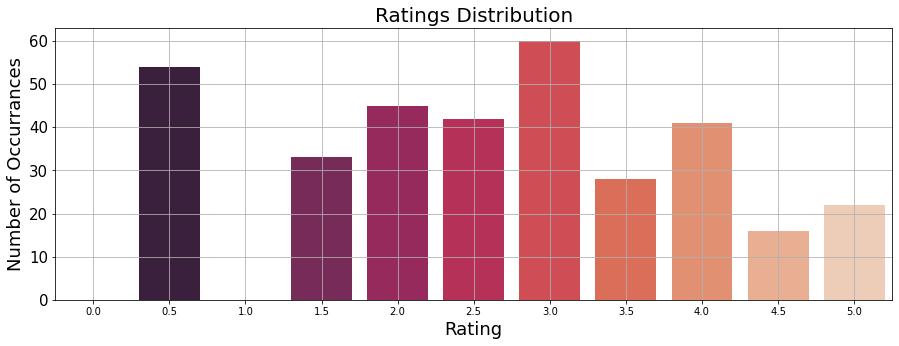

In [40]:
# test the user profile function then recommend movies for the given user
user_id = 517
n_movies = 10

user_profile(user_id, n_movies)
recommend_to_user(user_id, n_recs, use_words=True)

# Create a New UserId

In [41]:
def new_user_id():
    """
    function to determine the next available user id
    """
    return np.unique(np.array(ratings.userId)).max() + 1

# Prompt User to Rate a Movie
Given a title name (based on what movie the user has just watched or selected to rate), create a new rating by the user for the movie

In [42]:
def rate_movie(movie_title, userId):
    """
    function to prompt a user to rate a movie, given the title
    """
    try:
        movie_id = int(movies_df[movies_df.title == movie_title].movieId)
    except TypeError:
        return {}
    
    print(movie_title)
    rating = input('How do you rate this movie on a scale of 1-5')
    rating = {'userId':userId, 'movieId': movie_id, 'rating': rating}

    return rating

def add_rating_to_df(rating):
    """
    add a single new rating to the ratings data frame and surprise data set
    """
    new_ratings_df = pd.DataFrame(rating)
    
    # update the index to continue the existing index in the ratings dataframe
    new_ratings_df['new_index'] = [ratings.index.max()+1]
    new_ratings_df = new_ratings_df.set_index('new_index')
    
    updated_ratings_df = pd.concat([ratings, new_ratings_df], axis=0)
    updated_dataset = Dataset.load_from_df(new_ratings_df, reader)
    
    return updated_ratings_df, updated_dataset

In [43]:
new_user_id = new_user_id()
new_rating = rate_movie(movie_title='Spotlight (2015)', userId=new_user_id)
ratings_df, data = add_rating_to_df([new_rating])

ratings_df.tail()

Spotlight (2015)
How do you rate this movie on a scale of 1-53


,userId,movieId,rating
100832,610,168248,5
100833,610,168250,5
100834,610,168252,5
100835,610,170875,3
100836,611,142488,3


# Look at top 10 recommendations for all users 
In order to get a feel for the tendencies of the recommendation model. 
- determine the movies that are recommended most often to the given user profiles
- define a function to loop through all users and make recommendations for each

In [44]:
def get_most_recommened_movies_for_all_users(n_recs, use_words=False):
    """
    function to loop through all userIds and generate 5 movie recommendations for each. then count the total
    number of times each movie was recommended and return the top 10
    """
    userIds = list(np.unique(np.array(ratings.userId)))
#     userIds = userIds[:10]
    all_recs = []
    for Id in userIds:
        all_recs.extend(recommend_to_user(Id, n_recs, use_words=use_words))
        
    # get a list of unique movies
    unique_movies = list(np.unique(np.array(all_recs)))

    # count the number of times that movie was recommended and sort them
    occurance_count = [all_recs.count(movie) for movie in unique_movies]
    movie_rec_count = pd.DataFrame({'movie': unique_movies, 'rec_count': occurance_count}).sort_values(by='rec_count', ascending=False).set_index('movie')

    # get the top 10 most recommened movies
    movie_rec_count = movie_rec_count[:10]
    
    # plot the top 10 most recommended movies

    plt.figure(figsize=(15,10))
    ax = sns.barplot(data=movie_rec_count, x='rec_count', y=movie_rec_count.index, palette='rocket')
    # ax.bar_label(ax.containers[0], fmt='%.1f')
    plt.yticks(fontsize=15)
    plt.xlabel('Number of Recommendations', fontsize=18)
    plt.ylabel('', fontsize=18)
    plt.title('Most Common Movies Recommended', fontsize=20)
    plt.grid()
    plt.show()
    
    return movie_rec_count

### Look at the most common reccomendations

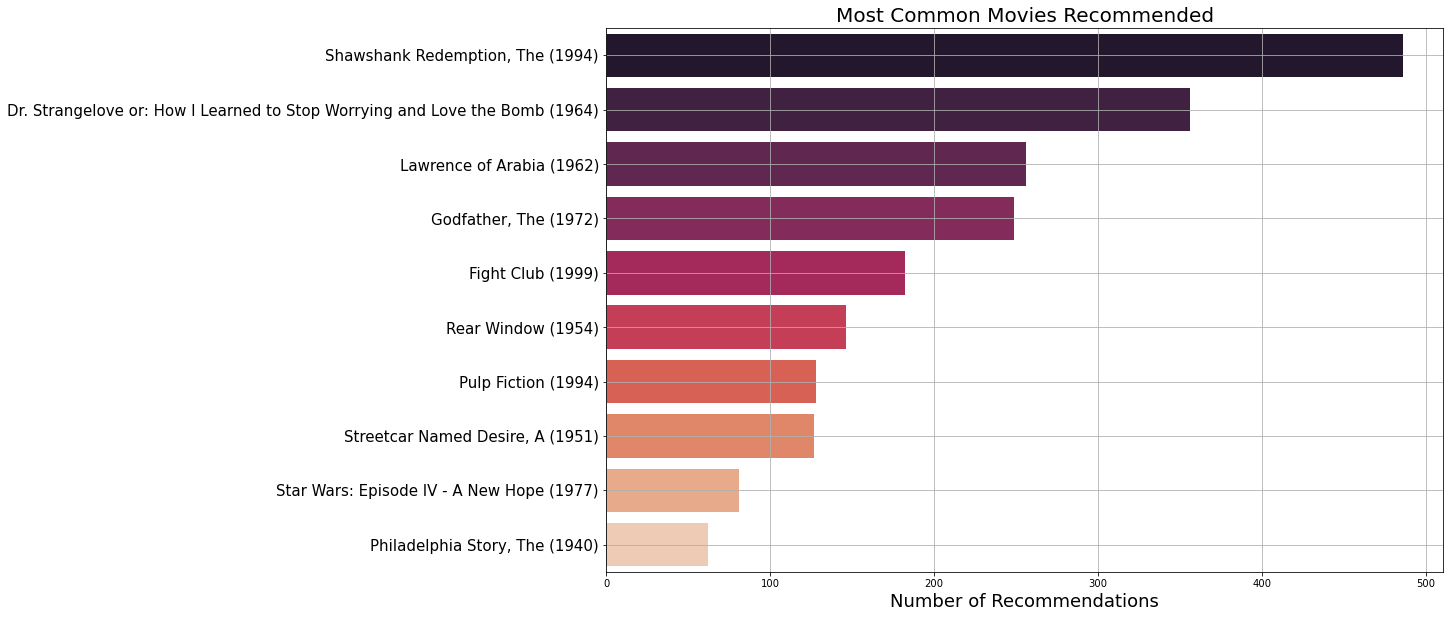

In [45]:
top_movie_recs = get_most_recommened_movies_for_all_users(5, use_words=False)

### Look at the most common reccomendations when the top key words for each user are included

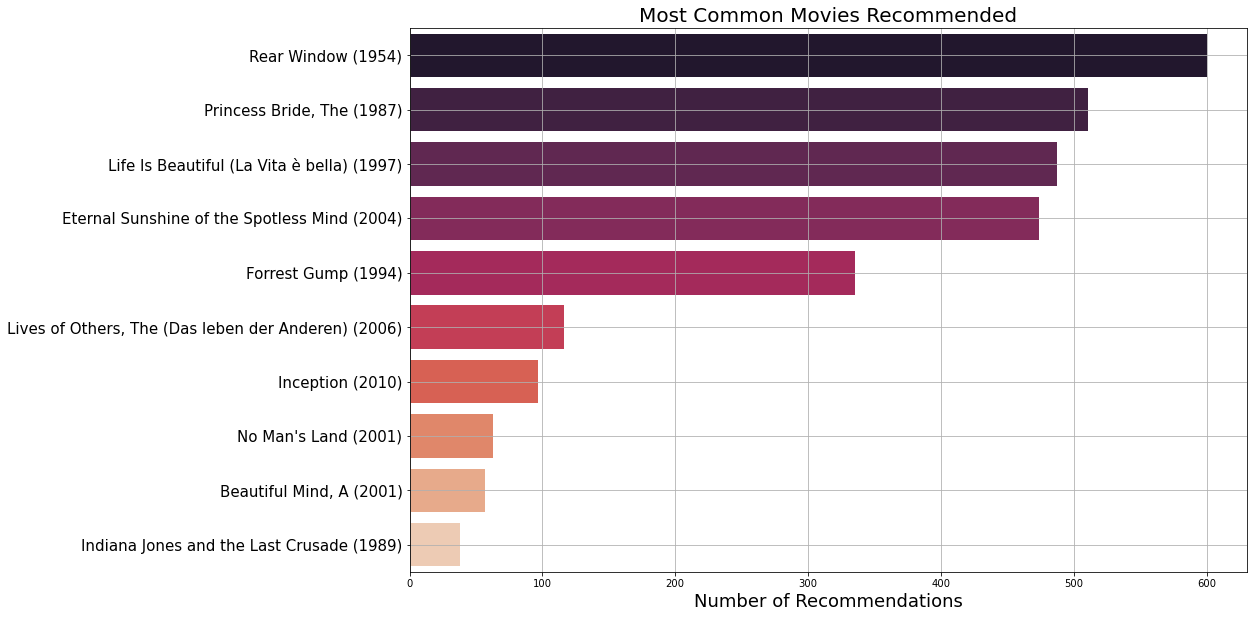

In [46]:
top_movie_recs_using_key_words = get_most_recommened_movies_for_all_users(5, use_words=True)

#### Fin